# Text Embeddings as Stock Features

## Context
Instead of reducing text to a single sentiment score, we encode the full semantic content into dense vector representations. These embeddings can capture nuance that sentiment analysis misses: competitive dynamics, growth trajectory, risk factors, etc.

## Pipeline
Text → Sentence-Transformer → Dense Embeddings (384-dim) → PCA (20-dim) → Tabular Features → LightGBM

## Why This Approach
- Captures richer information than sentiment (positive/negative/neutral is just 1 dimension; embeddings give hundreds)
- Off-the-shelf models work surprisingly well before any fine-tuning
- PCA-reduced embeddings can be directly plugged into any tabular ML model (LightGBM, XGBoost)
- Numerai's own tournament uses tabular features — this converts text into the same format

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 1. Load Sentence Transformer
We use `all-MiniLM-L6-v2` — a fast, lightweight model that produces 384-dim embeddings.
For finance-specific applications, `ProsusAI/finbert` or `sentence-transformers/all-mpnet-base-v2` could be better.

In [2]:
model = SentenceTransformer("all-MiniLM-L6-v2")
print(f"Model: all-MiniLM-L6-v2")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model: all-MiniLM-L6-v2
Embedding dimension: 384


## 2. Sample Financial Headlines
Same data as NB01 — in production, this comes from news APIs or Common Crawl.

In [3]:
headlines_data = [
    # Tech
    {
        "ticker": "AAPL",
        "sector": "Tech",
        "headline": "Apple reports record Q1 revenue driven by iPhone 15 demand",
    },
    {
        "ticker": "AAPL",
        "sector": "Tech",
        "headline": "Apple faces antitrust scrutiny from EU regulators over App Store practices",
    },
    {
        "ticker": "AAPL",
        "sector": "Tech",
        "headline": "Apple cuts prices in China amid fierce competition from Huawei",
    },
    {
        "ticker": "AAPL",
        "sector": "Tech",
        "headline": "Apple announces expanded share buyback program",
    },
    {
        "ticker": "MSFT",
        "sector": "Tech",
        "headline": "Microsoft Azure revenue grows 30% year-over-year beating estimates",
    },
    {
        "ticker": "MSFT",
        "sector": "Tech",
        "headline": "Microsoft's Copilot AI sees rapid enterprise adoption",
    },
    {
        "ticker": "MSFT",
        "sector": "Tech",
        "headline": "Microsoft invests additional $10B in OpenAI partnership",
    },
    {
        "ticker": "NVDA",
        "sector": "Tech",
        "headline": "NVIDIA data center revenue surges 400% on insatiable AI chip demand",
    },
    {
        "ticker": "NVDA",
        "sector": "Tech",
        "headline": "NVIDIA announces next-gen Blackwell GPU architecture",
    },
    {
        "ticker": "NVDA",
        "sector": "Tech",
        "headline": "NVIDIA faces export restrictions on advanced chips to China",
    },
    {
        "ticker": "GOOGL",
        "sector": "Tech",
        "headline": "Google Cloud turns profitable for first time in company history",
    },
    {
        "ticker": "GOOGL",
        "sector": "Tech",
        "headline": "DOJ proposes breaking up Google in landmark antitrust case",
    },
    {
        "ticker": "META",
        "sector": "Tech",
        "headline": "Meta's ad revenue rebounds strongly driven by AI recommendation engine",
    },
    {
        "ticker": "META",
        "sector": "Tech",
        "headline": "Meta Reality Labs losses reach $4B in Q4 raising investor concerns",
    },
    # Finance
    {
        "ticker": "JPM",
        "sector": "Finance",
        "headline": "JPMorgan reports strong Q4 earnings beating all analyst estimates",
    },
    {
        "ticker": "JPM",
        "sector": "Finance",
        "headline": "JPMorgan CEO warns of persistent inflation and geopolitical risks",
    },
    {
        "ticker": "JPM",
        "sector": "Finance",
        "headline": "JPMorgan faces $500M fine for compliance failures in trading desk",
    },
    {
        "ticker": "GS",
        "sector": "Finance",
        "headline": "Goldman Sachs profits surge on strong trading and dealmaking revenue",
    },
    {
        "ticker": "GS",
        "sector": "Finance",
        "headline": "Goldman Sachs pulls back from consumer banking after heavy losses",
    },
    # Energy
    {
        "ticker": "XOM",
        "sector": "Energy",
        "headline": "ExxonMobil completes $60B acquisition of Pioneer Natural Resources",
    },
    {
        "ticker": "XOM",
        "sector": "Energy",
        "headline": "Oil prices surge on Middle East tensions benefiting ExxonMobil",
    },
    {
        "ticker": "XOM",
        "sector": "Energy",
        "headline": "ExxonMobil faces shareholder revolt over climate change strategy",
    },
    {
        "ticker": "CVX",
        "sector": "Energy",
        "headline": "Chevron's LNG exports reach record levels as European demand grows",
    },
    {
        "ticker": "CVX",
        "sector": "Energy",
        "headline": "Chevron delays Hess acquisition amid arbitration dispute",
    },
    # Healthcare
    {
        "ticker": "PFE",
        "sector": "Healthcare",
        "headline": "Pfizer COVID vaccine revenue plummets 70% as pandemic demand fades",
    },
    {
        "ticker": "PFE",
        "sector": "Healthcare",
        "headline": "Pfizer's new cancer drug shows promising Phase 3 trial results",
    },
    {
        "ticker": "PFE",
        "sector": "Healthcare",
        "headline": "Pfizer acquires oncology biotech for $43B to diversify pipeline",
    },
    {
        "ticker": "JNJ",
        "sector": "Healthcare",
        "headline": "Johnson & Johnson settles talc lawsuits for $8.9 billion",
    },
    {
        "ticker": "JNJ",
        "sector": "Healthcare",
        "headline": "J&J's MedTech division drives growth with robotic surgery expansion",
    },
    # Auto
    {
        "ticker": "TSLA",
        "sector": "Auto",
        "headline": "Tesla misses Q4 delivery estimates amid production slowdown",
    },
    {
        "ticker": "TSLA",
        "sector": "Auto",
        "headline": "Tesla recalls 2 million vehicles over autopilot safety concerns",
    },
    {
        "ticker": "TSLA",
        "sector": "Auto",
        "headline": "Tesla slashes prices across entire lineup for third time this year",
    },
    {
        "ticker": "TSLA",
        "sector": "Auto",
        "headline": "Elon Musk unveils next-gen battery technology at Tesla investor day",
    },
]

df = pd.DataFrame(headlines_data)
print(
    f"Dataset: {len(df)} headlines, {df['ticker'].nunique()} tickers, {df['sector'].nunique()} sectors"
)

Dataset: 33 headlines, 12 tickers, 5 sectors


## 3. Generate Embeddings

In [4]:
# Generate embeddings for all headlines
embeddings = model.encode(
    df["headline"].tolist(), show_progress_bar=True, convert_to_numpy=True
)
print(f"Embedding matrix shape: {embeddings.shape}")  # (n_headlines, 384)
print(
    f"Embedding norm range: [{np.linalg.norm(embeddings, axis=1).min():.3f}, {np.linalg.norm(embeddings, axis=1).max():.3f}]"
)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Embedding matrix shape: (33, 384)
Embedding norm range: [1.000, 1.000]


## 4. Visualize Embedding Space
Use PCA/t-SNE to project 384-dim embeddings to 2D. We should see sector-level clustering.

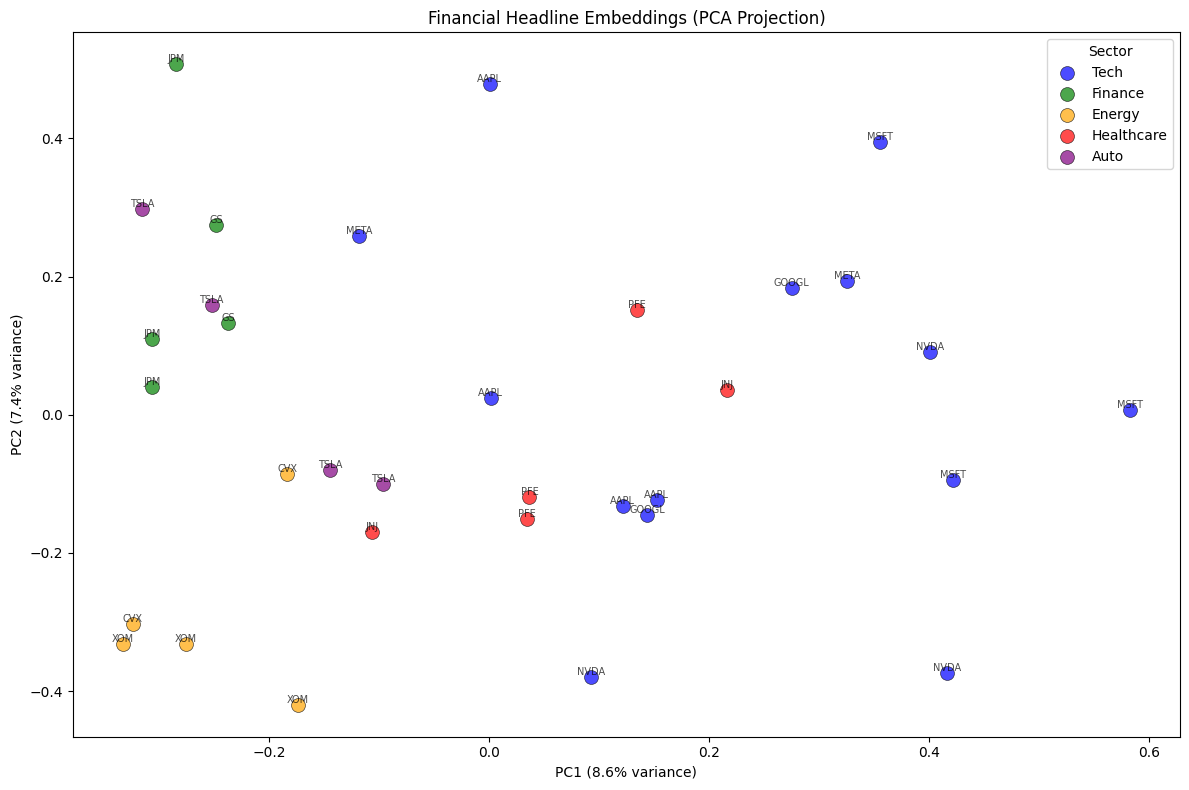

Total variance explained by 2 PCs: 16.0%


In [5]:
# PCA to 2D for visualization
pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(12, 8))
sector_colors = {
    "Tech": "blue",
    "Finance": "green",
    "Energy": "orange",
    "Healthcare": "red",
    "Auto": "purple",
}

for sector, color in sector_colors.items():
    mask = df["sector"] == sector
    ax.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=color,
        label=sector,
        alpha=0.7,
        s=100,
        edgecolors="black",
        linewidth=0.5,
    )
    # Annotate with ticker
    for idx in df[mask].index:
        ax.annotate(
            df.loc[idx, "ticker"],
            (embeddings_2d[idx, 0], embeddings_2d[idx, 1]),
            fontsize=7,
            alpha=0.7,
            ha="center",
            va="bottom",
        )

ax.set_xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)")
ax.set_ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)")
ax.set_title("Financial Headline Embeddings (PCA Projection)")
ax.legend(title="Sector")
plt.tight_layout()
plt.show()
print(
    f"Total variance explained by 2 PCs: {pca_2d.explained_variance_ratio_.sum():.1%}"
)

## 5. PCA Feature Engineering
Reduce 384-dim embeddings to a manageable number of features for tabular ML.
Key question: how many PCA components capture enough variance?

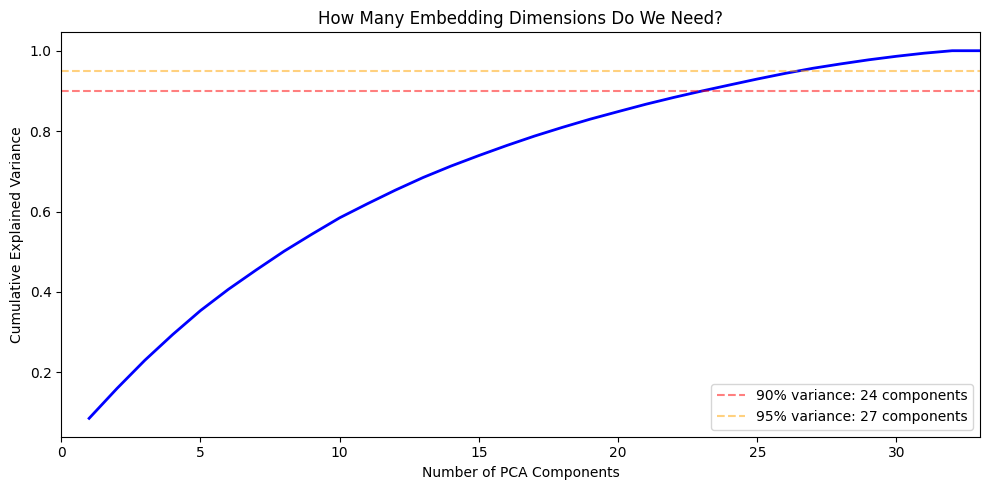

Components for 90% variance: 24
Components for 95% variance: 27
Components for 99% variance: 31


In [6]:
# Explained variance analysis
pca_full = PCA(n_components=min(len(embeddings), embeddings.shape[1]))
pca_full.fit(embeddings)

cumvar = np.cumsum(pca_full.explained_variance_ratio_)
n_90 = np.searchsorted(cumvar, 0.90) + 1
n_95 = np.searchsorted(cumvar, 0.95) + 1
n_99 = np.searchsorted(cumvar, 0.99) + 1

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, len(cumvar) + 1), cumvar, "b-", linewidth=2)
ax.axhline(
    y=0.90,
    color="r",
    linestyle="--",
    alpha=0.5,
    label=f"90% variance: {n_90} components",
)
ax.axhline(
    y=0.95,
    color="orange",
    linestyle="--",
    alpha=0.5,
    label=f"95% variance: {n_95} components",
)
ax.set_xlabel("Number of PCA Components")
ax.set_ylabel("Cumulative Explained Variance")
ax.set_title("How Many Embedding Dimensions Do We Need?")
ax.legend()
ax.set_xlim(0, min(50, len(cumvar)))
plt.tight_layout()
plt.show()
print(f"Components for 90% variance: {n_90}")
print(f"Components for 95% variance: {n_95}")
print(f"Components for 99% variance: {n_99}")

## 6. Aggregate Embeddings Per Stock
Average headline embeddings per ticker, then apply PCA.

In [7]:
# Aggregate: mean embedding per ticker
ticker_embeddings = {}
for ticker in df["ticker"].unique():
    mask = df["ticker"] == ticker
    ticker_embeddings[ticker] = embeddings[mask].mean(axis=0)

ticker_emb_matrix = np.stack(list(ticker_embeddings.values()))
ticker_names = list(ticker_embeddings.keys())
print(f"Per-ticker embedding matrix: {ticker_emb_matrix.shape}")

# PCA reduce to 20 features
n_components = min(20, len(ticker_names) - 1)
pca = PCA(n_components=n_components)
ticker_features = pca.fit_transform(ticker_emb_matrix)
print(f"Reduced feature matrix: {ticker_features.shape}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.1%}")

# Create feature DataFrame
feature_cols = [f"emb_pc{i}" for i in range(n_components)]
features_df = pd.DataFrame(ticker_features, columns=feature_cols, index=ticker_names)
features_df.index.name = "ticker"
print("\nPer-ticker embedding features (first 5 PCs):")
print(features_df.iloc[:, :5].round(3).to_string())

Per-ticker embedding matrix: (12, 384)
Reduced feature matrix: (12, 11)
Variance explained: 100.0%

Per-ticker embedding features (first 5 PCs):
        emb_pc0  emb_pc1  emb_pc2  emb_pc3  emb_pc4
ticker                                             
AAPL      0.090    0.027    0.123   -0.187    0.116
MSFT      0.442   -0.038    0.098    0.072    0.026
NVDA      0.278    0.160   -0.021   -0.392   -0.290
GOOGL     0.236   -0.163    0.389    0.206   -0.126
META      0.105   -0.117   -0.009   -0.013    0.364
JPM      -0.242   -0.310   -0.034    0.025    0.119
GS       -0.398   -0.442    0.070   -0.174   -0.191
XOM      -0.250    0.420    0.117    0.123   -0.071
CVX      -0.331    0.306    0.082    0.071   -0.105
PFE       0.077    0.002   -0.494   -0.119   -0.053
JNJ       0.088   -0.054   -0.305    0.458   -0.142
TSLA     -0.095    0.208   -0.016   -0.070    0.352


## 7. Train Simple Predictor (LightGBM)
Use embedding features to predict synthetic stock returns. In production, these would be real returns.

In [ ]:
# Synthetic returns (in production: real stock returns from Numerai or market data)
np.random.seed(42)
sectors = df.groupby("ticker")["sector"].first()
# Simulate: tech stocks did well, energy mixed, etc.
sector_bias = {"Tech": 0.05, "Finance": 0.02, "Energy": -0.01, "Healthcare": 0.0, "Auto": -0.03}
returns = np.array([sector_bias[sectors[t]] + np.random.normal(0, 0.03) for t in ticker_names])
features_df["return"] = returns

print("Synthetic returns by ticker:")
for t, r in zip(ticker_names, returns):
    print(f"  {t}: {r:+.3f}")

In [ ]:
try:
    import lightgbm as lgb
    
    X = features_df[feature_cols].values
    y = (features_df["return"] > features_df["return"].median()).astype(int)  # binary: above/below median
    
    model_lgb = lgb.LGBMClassifier(n_estimators=50, max_depth=3, verbose=-1, random_state=42)
    model_lgb.fit(X, y)
    
    # Feature importance
    importances = model_lgb.feature_importances_
    sorted_idx = np.argsort(importances)[::-1][:10]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh([feature_cols[i] for i in sorted_idx[::-1]], importances[sorted_idx[::-1]], color='steelblue', edgecolor='black')
    ax.set_xlabel("Feature Importance (split count)")
    ax.set_title("Which Embedding Dimensions Predict Returns?")
    plt.tight_layout()
    plt.show()
    
    print(f"\nTraining accuracy: {model_lgb.score(X, y):.1%}")
    print("(Note: with only ~10 samples, this is illustrative — real evaluation needs hundreds of stocks)")
except ImportError:
    print("LightGBM not installed. Run: uv add lightgbm")
    print("Skipping model training — the embedding features above are the main deliverable.")

## 8. Cosine Similarity Between Stocks
Embedding similarity reveals which stocks are semantically related based on their news coverage.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(ticker_emb_matrix)
sim_df = pd.DataFrame(sim_matrix, index=ticker_names, columns=ticker_names)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(sim_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(len(ticker_names)))
ax.set_yticks(range(len(ticker_names)))
ax.set_xticklabels(ticker_names, rotation=45, ha='right')
ax.set_yticklabels(ticker_names)
plt.colorbar(im, label="Cosine Similarity")
ax.set_title("Stock Similarity Based on News Embeddings")

# Annotate cells
for i in range(len(ticker_names)):
    for j in range(len(ticker_names)):
        ax.text(j, i, f"{sim_matrix[i, j]:.2f}", ha="center", va="center", fontsize=7,
                color="white" if abs(sim_matrix[i, j]) > 0.5 else "black")

plt.tight_layout()
plt.show()

## Discussion & Interview Talking Points

### Strengths
- **Richer than sentiment**: 384 dimensions capture topic, tone, entities, relationships, competitive context
- **Drop-in for tabular ML**: PCA components work with any model (LightGBM, XGBoost, neural nets)
- **Similarity as a feature itself**: Cosine similarity reveals semantic stock relationships (could feed into NB04 knowledge graphs)

### Weaknesses
- **Dimensionality**: Even after PCA, embeddings add many features. In Numerai's setting with ~5,000 stocks, this can overfit
- **Generic model**: all-MiniLM-L6-v2 is not trained on financial text. FinBERT or a fine-tuned model (NB07) would be better
- **Aggregation loss**: Averaging headline embeddings loses temporal ordering and article-level nuance

### Key Insight for Numerai
- **Embedding features are likely more orthogonal than sentiment** because they capture multidimensional semantics, not just positive/negative
- But the real power comes from **fine-tuned embeddings** (NB05: contrastive) or **probed representations** (NB06: layer-specific)
- Research (Chen et al., 2022) shows LLM embeddings outperform traditional technical signals on global equities

### Extensions (TODO)
- [ ] Compare: all-MiniLM-L6-v2 vs FinBERT vs all-mpnet-base-v2
- [ ] Try UMAP instead of PCA for better non-linear structure preservation
- [ ] Use FAISS for efficient nearest-neighbor stock lookup (you already have FAISS experience!)
- [ ] Temporal embeddings: embed text per week, track embedding drift over time
- [ ] Feed embedding features into Numerai tournament alongside their provided features